##  GAN
- generate model / discriminator를 구성
  - GAN 의 이론적 배경은 다들 알고 있을테니 구조적 특징을 살펴보려한다.
 
- D(x) : discriminator
  - input : image (3 * 64 * 64 데이터를 사용할 예정)
  - out : prob ( 1: real, 0 : generated로 훈련 계획)

- G(z) : generater
  - z :정규분포에서 뽑은 n-dim의 벡터 -> 사실 이 z가 애매하다 생각되는건 천천히 살펴보자
  - output : generated image
  
### DCGAN
-  GAN의 파생모델인데 그냥 기본 CNN based GAN모델이라 생각하면된다. 기본이기때문에, 파생 모델들을 이 스켈레톤을 가져다가 구성 모델만 바꾸는게 보통이다.


In [1]:
from __future__ import print_function

import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dest
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

manualSeed = 999

random.seed(manualSeed)
torch.manual_seed(manualSeed)

### parametart
- dataroot : 데이터셋의 폴더 경로
- workers : DataLoader에서 사용할 thread num
- batch_size : dcgan은 128을 사용
- imagesize : 이미지 크기
- nc : 이미지 채널수 rgd -> 3
- nz : random vector dim
- ngf : 생성자를 통과할때, feature의 채널 수
- ndf : 구분자의 레이어마다의 채널수
- num_epochs : 최대 에폭
- lr : DCGAN은 0.0002
- beta : adam optim의 하이퍼파라미터값 0.5
- ngpu : gpu  수

In [2]:
dataroot = "/raid/jskim/data/celeba"
workers = 2
batch_size = 128
image_size = 64
nc = 3
nz = 100
ngf = 64
ndf =64
num_epochs = 5
lr = 0.0002
beta1 = 0.5
ngpu = 1

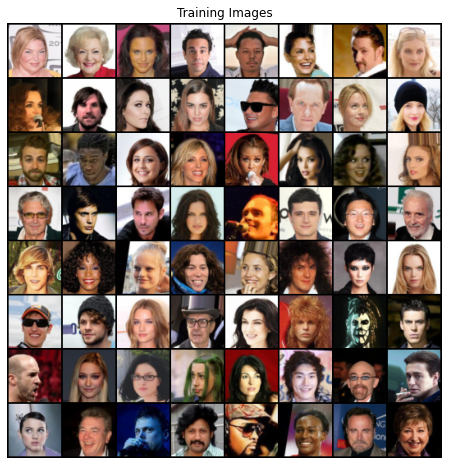

In [4]:
dataset = dest.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]
                           )
                          )

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [10]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [13]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, input):
        return self.main(input)

In [14]:
# 생성자를 만듭니다
netG = Generator(ngpu).to(device)

# 모든 가중치의 평균을 0, 분산을 0.02로 초기화 하기 위해
# weight_init 함수를 적용시킵니다
netG.apply(weights_init)

# 모델의 구조를 출력합니다
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


## ConvTranspose

> https://simonjisu.github.io/deeplearning/2019/10/27/convtranspose2d.html

- 짧게 요약하면 up smapling하는 layer



In [15]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # 입력 데이터의 크기는 (nc) x 64 x 64 입니다
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 위의 계층을 통과한 데이터의 크기. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # 위의 계층을 통과한 데이터의 크기. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # 위의 계층을 통과한 데이터의 크기. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # 위의 계층을 통과한 데이터의 크기. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [16]:
netD = Discriminator(ngpu).to(device)

# 필요한 경우 multi-gpu를 설정 해주세요
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# 모든 가중치의 평균을 0, 분산을 0.02로 초기화 하기 위해
# weight_init 함수를 적용시킵니다
netD.apply(weights_init)

# 모델의 구조를 출력합니다
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [17]:
# BCELoss 함수의 인스턴스를 생성합니다
criterion = nn.BCELoss()

# 생성자의 학습상태를 확인할 잠재 공간 벡터를 생성합니다
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# 학습에 사용되는 참/거짓의 라벨을 정합니다
real_label = 1.
fake_label = 0.

# G와 D에서 사용할 Adam옵티마이저를 생성합니다
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [18]:
# 학습 과정

# 학습상태를 체크하기 위해 손실값들을 저장합니다
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# 에폭(epoch) 반복
for epoch in range(num_epochs):
    # 한 에폭 내에서 배치 반복
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) D 신경망을 업데이트 합니다: log(D(x)) + log(1 - D(G(z)))를 최대화 합니다
        ###########################
        ## 진짜 데이터들로 학습을 합니다
        netD.zero_grad()
        # 배치들의 사이즈나 사용할 디바이스에 맞게 조정합니다
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label,
                           dtype=torch.float, device=device)
        # 진짜 데이터들로 이루어진 배치를 D에 통과시킵니다
        output = netD(real_cpu).view(-1)
        # 손실값을 구합니다
        errD_real = criterion(output, label)
        # 역전파의 과정에서 변화도를 계산합니다
        errD_real.backward()
        D_x = output.mean().item()

        ## 가짜 데이터들로 학습을 합니다
        # 생성자에 사용할 잠재공간 벡터를 생성합니다
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # G를 이용해 가짜 이미지를 생성합니다
        fake = netG(noise)
        label.fill_(fake_label)
        # D를 이용해 데이터의 진위를 판별합니다
        output = netD(fake.detach()).view(-1)
        # D의 손실값을 계산합니다
        errD_fake = criterion(output, label)
        # 역전파를 통해 변화도를 계산합니다. 이때 앞서 구한 변화도에 더합니다(accumulate)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # 가짜 이미지와 진짜 이미지 모두에서 구한 손실값들을 더합니다
        # 이때 errD는 역전파에서 사용되지 않고, 이후 학습 상태를 리포팅(reporting)할 때 사용합니다
        errD = errD_real + errD_fake
        # D를 업데이트 합니다
        optimizerD.step()

        ############################
        # (2) G 신경망을 업데이트 합니다: log(D(G(z)))를 최대화 합니다
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # 생성자의 손실값을 구하기 위해 진짜 라벨을 이용할 겁니다
        # 우리는 방금 D를 업데이트했기 때문에, D에 다시 가짜 데이터를 통과시킵니다.
        # 이때 G는 업데이트되지 않았지만, D가 업데이트 되었기 때문에 앞선 손실값가 다른 값이 나오게 됩니다
        output = netD(fake).view(-1)
        # G의 손실값을 구합니다
        errG = criterion(output, label)
        # G의 변화도를 계산합니다
        errG.backward()
        D_G_z2 = output.mean().item()
        # G를 업데이트 합니다
        optimizerG.step()

        # 훈련 상태를 출력합니다
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # 이후 그래프를 그리기 위해 손실값들을 저장해둡니다
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # fixed_noise를 통과시킨 G의 출력값을 저장해둡니다
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/1583]	Loss_D: 2.8163	Loss_G: 1.5875	D(x): 0.1352	D(G(z)): 0.2489 / 0.2641
[0/5][50/1583]	Loss_D: 0.1573	Loss_G: 5.4807	D(x): 0.9388	D(G(z)): 0.0167 / 0.0083
[0/5][100/1583]	Loss_D: 0.2596	Loss_G: 5.3954	D(x): 0.8940	D(G(z)): 0.0266 / 0.0084
[0/5][150/1583]	Loss_D: 0.3626	Loss_G: 3.3294	D(x): 0.8428	D(G(z)): 0.1063 / 0.0605
[0/5][200/1583]	Loss_D: 1.8277	Loss_G: 11.9462	D(x): 0.9490	D(G(z)): 0.7567 / 0.0000
[0/5][250/1583]	Loss_D: 0.3287	Loss_G: 4.3403	D(x): 0.9239	D(G(z)): 0.1984 / 0.0189
[0/5][300/1583]	Loss_D: 0.6100	Loss_G: 2.7648	D(x): 0.7716	D(G(z)): 0.2237 / 0.0942
[0/5][350/1583]	Loss_D: 0.4089	Loss_G: 3.8536	D(x): 0.9114	D(G(z)): 0.2346 / 0.0382
[0/5][400/1583]	Loss_D: 0.5967	Loss_G: 6.7430	D(x): 0.9107	D(G(z)): 0.3532 / 0.0026
[0/5][450/1583]	Loss_D: 0.5891	Loss_G: 4.8526	D(x): 0.8274	D(G(z)): 0.2710 / 0.0157
[0/5][500/1583]	Loss_D: 0.6413	Loss_G: 6.4532	D(x): 0.9283	D(G(z)): 0.3715 / 0.0037
[0/5][550/1583]	Loss_D: 0.7063	Loss_G: 3.2488	D(x): 

[3/5][50/1583]	Loss_D: 0.6191	Loss_G: 2.7745	D(x): 0.7832	D(G(z)): 0.2729 / 0.0799
[3/5][100/1583]	Loss_D: 0.6887	Loss_G: 1.3862	D(x): 0.6057	D(G(z)): 0.0941 / 0.2927
[3/5][150/1583]	Loss_D: 0.5877	Loss_G: 1.9459	D(x): 0.6350	D(G(z)): 0.0623 / 0.1775
[3/5][200/1583]	Loss_D: 0.4521	Loss_G: 2.9428	D(x): 0.8187	D(G(z)): 0.1999 / 0.0667
[3/5][250/1583]	Loss_D: 0.6151	Loss_G: 1.8231	D(x): 0.6420	D(G(z)): 0.0806 / 0.1989
[3/5][300/1583]	Loss_D: 1.3940	Loss_G: 5.9918	D(x): 0.9620	D(G(z)): 0.6844 / 0.0044
[3/5][350/1583]	Loss_D: 0.7561	Loss_G: 1.1417	D(x): 0.6160	D(G(z)): 0.1797 / 0.3527
[3/5][400/1583]	Loss_D: 0.5947	Loss_G: 2.4870	D(x): 0.8046	D(G(z)): 0.2658 / 0.1121
[3/5][450/1583]	Loss_D: 0.4450	Loss_G: 2.6803	D(x): 0.7489	D(G(z)): 0.1141 / 0.0886
[3/5][500/1583]	Loss_D: 0.6425	Loss_G: 0.8686	D(x): 0.5917	D(G(z)): 0.0498 / 0.4723
[3/5][550/1583]	Loss_D: 0.5218	Loss_G: 2.9018	D(x): 0.7981	D(G(z)): 0.2275 / 0.0697
[3/5][600/1583]	Loss_D: 0.6125	Loss_G: 1.8697	D(x): 0.6281	D(G(z)): 0.0793 / 

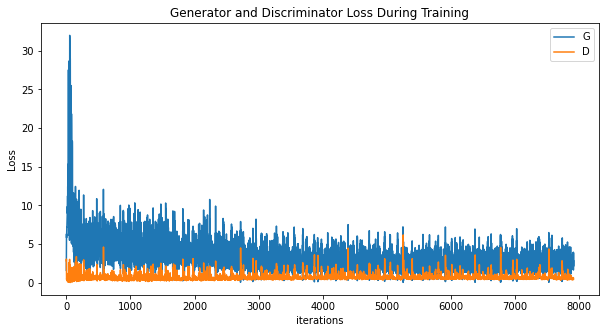

In [19]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

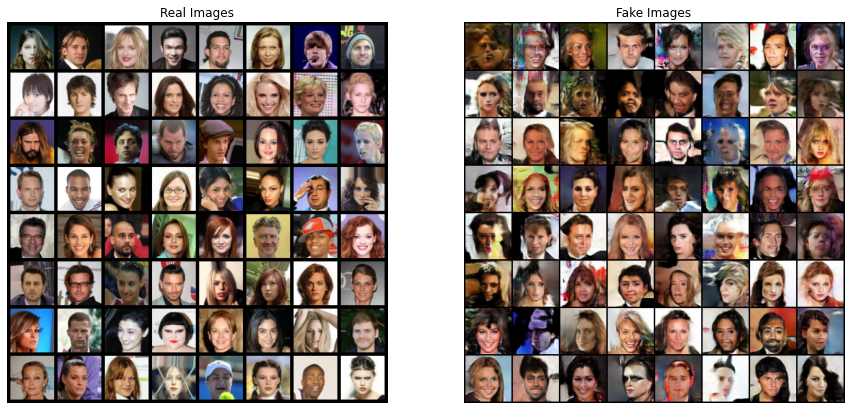

In [20]:
# dataloader에서 진짜 데이터들을 가져옵니다
real_batch = next(iter(dataloader))

# 진짜 이미지들을 화면에 출력합니다
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# 가짜 이미지들을 화면에 출력합니다
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()